In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import math
import numpy as np
import time
import matplotlib.pyplot as plt

# 设置随机种子
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{DEVICE}")

cuda


In [2]:
def get_avg_size(root_dir):
    """计算所有图片宽高的均值（向上取整）"""
    widths, heights = [], []
    valid_ext = ('.jpg', '.png', '.jpeg')
    
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(valid_ext):
                try:
                    with Image.open(os.path.join(root, file)) as img:
                        widths.append(img.width)
                        heights.append(img.height)
                except:
                    continue
    
    if not widths:
        raise ValueError("未找到图片，请检查路径！")
        
    mean_w = math.ceil(sum(widths) / len(widths))
    mean_h = math.ceil(sum(heights) / len(heights))
    return mean_h, mean_w

class VehicleDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        path = self.img_paths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            return torch.zeros((3, 100, 100)), label

DATA_ROOT = './cardata'  
BATCH_SIZE = 16

try:
    # 1. 获取尺寸
    target_h, target_w = get_avg_size(DATA_ROOT)
    print(f"Target Resize Size: ({target_h}, {target_w})")

    # 2. 定义 Transform
    data_transform = transforms.Compose([
        transforms.Resize((target_h, target_w)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # 3. 划分数据集
    classes = ['bus', 'car', 'truck']
    class_map = {name: i for i, name in enumerate(classes)}
    train_paths, train_labels = [], []
    test_paths, test_labels = [], []

    for cls_name in classes:
        cls_dir = os.path.join(DATA_ROOT, cls_name)
        if not os.path.exists(cls_dir): continue
            
        images = [os.path.join(cls_dir, x) for x in os.listdir(cls_dir) 
                  if x.lower().endswith(('.jpg', '.png', '.jpeg'))]
        np.random.shuffle(images)
        
        split_idx = int(len(images) * 0.2)
        test_imgs = images[:split_idx]
        train_imgs = images[split_idx:]
        label = class_map[cls_name]
        
        test_paths.extend(test_imgs); test_labels.extend([label]*len(test_imgs))
        train_paths.extend(train_imgs); train_labels.extend([label]*len(train_imgs))
        print(f"类别 {cls_name}: Train={len(train_imgs)}, Test={len(test_imgs)}")

    train_loader = DataLoader(VehicleDataset(train_paths, train_labels, data_transform), 
                              batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(VehicleDataset(test_paths, test_labels, data_transform), 
                             batch_size=BATCH_SIZE, shuffle=False)
    
except Exception as e:
    print(f"数据加载出错: {e}")

Target Resize Size: (111, 94)
类别 bus: Train=175, Test=43
类别 car: Train=624, Test=155
类别 truck: Train=288, Test=72


In [3]:
class StandardCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(StandardCNN, self).__init__()
        
        # === 核心区别：使用 PyTorch 原生卷积 ===
        # 输入: 3通道, 输出: 16通道, 卷积核: 3x3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        
        # 输入: 16通道, 输出: 32通道, 卷积核: 3x3
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # ====================================
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        # 使用 AdaptiveAvgPool 简化尺寸计算
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4)) 
        
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Conv1 -> ReLU -> Pool
        x = self.pool(self.relu(self.conv1(x)))
        # Conv2 -> ReLU -> Pool
        x = self.pool(self.relu(self.conv2(x)))
        
        x = self.adaptive_pool(x)
        x = x.reshape(-1, 32 * 4 * 4) # 使用 reshape 展平
        
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = StandardCNN(num_classes=3).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 数据记录容器
history = {
    'train_loss': [], 'train_acc': [],
    'test_acc': [], 'time': []
}


In [4]:
EPOCHS = 10 

print(f"{'Epoch':^7} | {'Time(s)':^8} | {'Loss':^8} | {'Train Acc':^10} | {'Test Acc':^10}")
print("-" * 55)

total_start = time.time()

for epoch in range(EPOCHS):
    ep_start = time.time()
    
    # --- 训练 ---
    model.train()
    run_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        
        run_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total_train += lbls.size(0)
        correct_train += (preds == lbls).sum().item()
        
    # --- 验证 ---
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            total_test += lbls.size(0)
            correct_test += (preds == lbls).sum().item()
            
    # --- 记录 ---
    ep_end = time.time()
    ep_time = ep_end - ep_start
    
    avg_loss = run_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    test_acc = 100 * correct_test / total_test
    
    history['train_loss'].append(avg_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)
    history['time'].append(ep_time)
    
    print(f"{epoch+1:^7} | {ep_time:^8.4f} | {avg_loss:^8.4f} | {train_acc:^9.2f}% | {test_acc:^9.2f}%")

print("-" * 55)
print(f"训练结束，总耗时: {time.time() - total_start:.2f}s")

 Epoch  | Time(s)  |   Loss   | Train Acc  |  Test Acc 
-------------------------------------------------------
   1    | 15.1285  |  0.7622  |   64.58  % |   79.63  %
   2    |  6.2105  |  0.4331  |   84.18  % |   85.19  %
   3    |  3.1055  |  0.3315  |   87.58  % |   88.15  %
   4    |  3.4127  |  0.2774  |   90.98  % |   86.67  %
   5    |  4.0276  |  0.2604  |   90.25  % |   88.52  %
   6    |  3.7876  |  0.2510  |   90.25  % |   90.37  %
   7    |  3.0367  |  0.2082  |   92.36  % |   88.15  %
   8    |  2.9162  |  0.2167  |   90.89  % |   90.74  %
   9    |  2.8322  |  0.1865  |   93.65  % |   90.37  %
  10    |  2.7997  |  0.1965  |   92.18  % |   91.85  %
-------------------------------------------------------
训练结束，总耗时: 47.27s


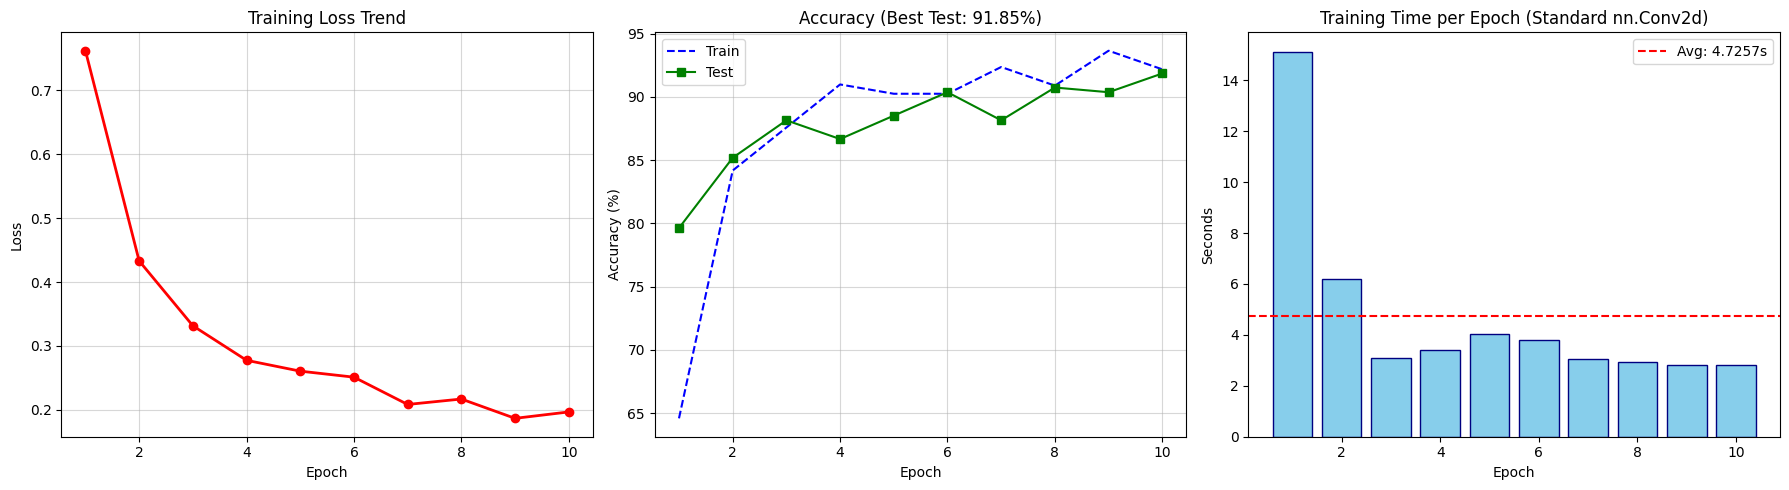

In [5]:
epochs_range = range(1, len(history['train_loss']) + 1)
avg_time = sum(history['time']) / len(history['time'])

plt.figure(figsize=(18, 5))

# 1. Loss 变化
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], 'r-o', linewidth=2)
plt.title('Training Loss Trend')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.5)

# 2. 精度变化
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_acc'], 'b--', label='Train')
plt.plot(epochs_range, history['test_acc'], 'g-s', label='Test')
plt.title(f'Accuracy (Best Test: {max(history["test_acc"]):.2f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.5)

# 3. 训练耗时
plt.subplot(1, 3, 3)
plt.bar(epochs_range, history['time'], color='skyblue', edgecolor='navy')
plt.axhline(y=avg_time, color='red', linestyle='--', label=f'Avg: {avg_time:.4f}s')
plt.title('Training Time per Epoch (Standard nn.Conv2d)')
plt.xlabel('Epoch')
plt.ylabel('Seconds')
plt.legend()

plt.tight_layout()
plt.show()